Loading model output results...
Loading geographic and mask data...

--- Generating Main Comparison Map Visualizations ---
Sample Index: 0, Time Step Index: 0
Dynamic color range calculated: vmin=-46.90, vmax=65.14


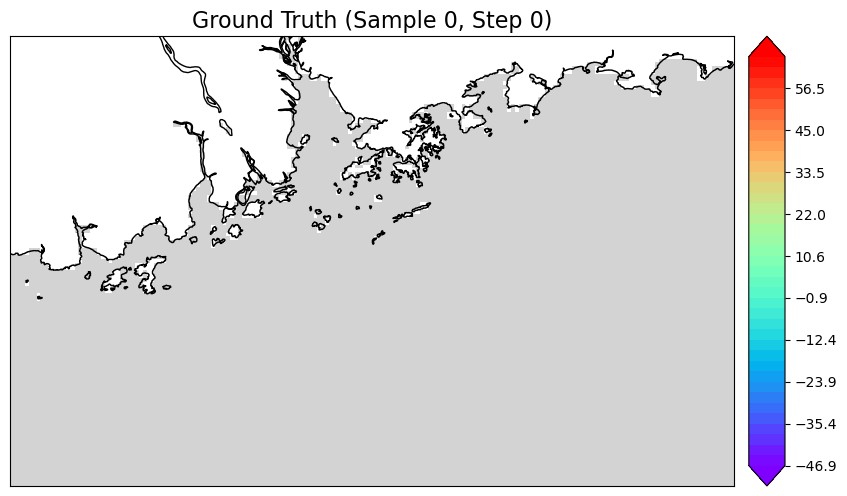

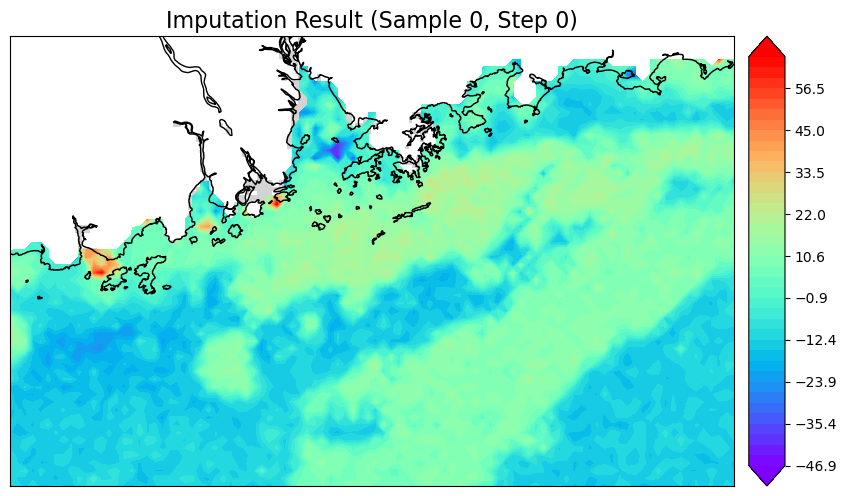


--- Generating Specific Map for ground_truth[0, :, 0] ---
Dynamic color range for slice [0,:,0]: vmin=-1.12, vmax=1.27


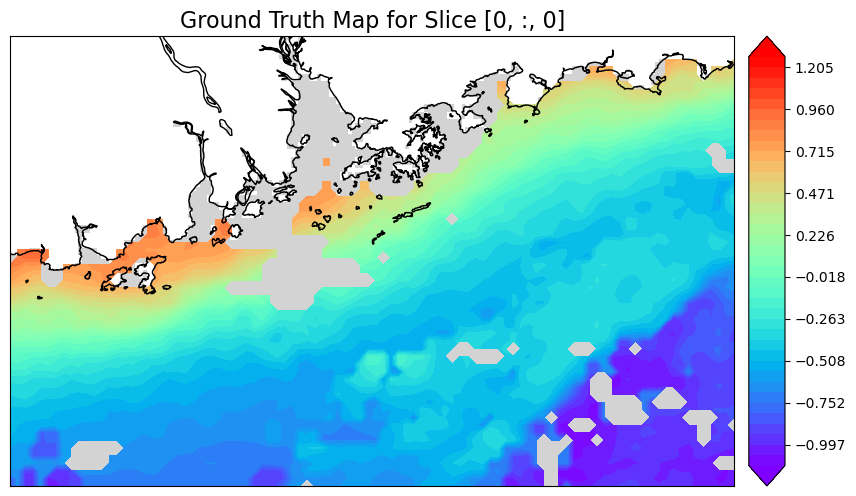


--- Generating Time Series Visualization ---
Node Index: 783


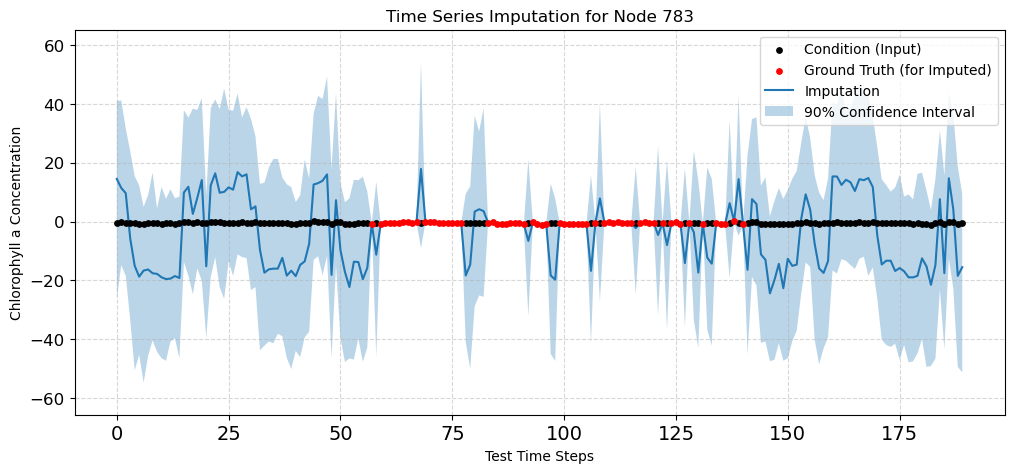

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.basemap import Basemap

# --- 1. Configuration (Modify as needed) ---
# Select sample index (0-18) and time step index (0-9) for the main comparison maps
SAMPLE_IDX_FOR_MAP = 0
TIME_IDX_FOR_MAP = 0

# Select node index (0-4442) for the time series
NODE_IDX_FOR_TIMESERIES = 783 # An arbitrary node

# --- 2. File Paths ---
RESULTS_FILE_PATH = Path("results/pre/bm_0.15.npz")
DATA_DIR = Path("data/pre")

# --- 3. Load Data ---
print("Loading model output results...")
results = np.load(RESULTS_FILE_PATH)
ground_truth = results['ground_truth']
median_pred = results['median_pred']
eval_points = results['eval_points']
lower_bound = results['lower_bound']
upper_bound = results['upper_bound']

print("Loading geographic and mask data...")
is_sea_mask = np.load(DATA_DIR / "is_sea.npy").astype(bool)
lon = np.load(DATA_DIR / "lon.npy")
lati = np.load(DATA_DIR / "lati.npy")
mask = np.load(DATA_DIR / "PRE_origin_chla_mask.npy")  # 维度: (977, 60, 96)

# --- 4. Helper Function ---
def reconstruct_grid(data_slice_flat, sea_mask):
    """Reconstructs a geographic grid (60, 96) from flat sea node data (4443,)."""
    grid = np.full(sea_mask.shape, np.nan, dtype=data_slice_flat.dtype)
    grid[sea_mask] = data_slice_flat
    return grid

# --- 5. Map Visualization Functions ---

def plot_maps_final_style():
    """Plots Ground Truth and Imputation maps with a dynamic and shared color scale."""
    print(f"\n--- Generating Main Comparison Map Visualizations ---")
    print(f"Sample Index: {SAMPLE_IDX_FOR_MAP}, Time Step Index: {TIME_IDX_FOR_MAP}")

    # Extract data slices
    gt_slice = ground_truth[SAMPLE_IDX_FOR_MAP, :, TIME_IDX_FOR_MAP]
    pred_slice = median_pred[SAMPLE_IDX_FOR_MAP, :, TIME_IDX_FOR_MAP]
    eval_slice = eval_points[SAMPLE_IDX_FOR_MAP, :, TIME_IDX_FOR_MAP]
    
    # For visualization, we show the sparse ground truth (only imputed points)
    gt_slice_masked = np.where(eval_slice == 1, gt_slice, np.nan)

    # --- NEW: Calculate dynamic color range based on the FULL data for a fair comparison ---
    # Note: We use the unmasked gt_slice and the full pred_slice to set the color scale,
    # ensuring both plots are on the same, accurate scale.
    vmin = np.nanmin([np.nanmin(gt_slice), np.nanmin(pred_slice)])
    vmax = np.nanmax([np.nanmax(gt_slice), np.nanmax(pred_slice)])
    print(f"Dynamic color range calculated: vmin={vmin:.2f}, vmax={vmax:.2f}")
    levels = np.linspace(vmin, vmax, 40)

    # Reconstruct grids
    gt_grid = reconstruct_grid(gt_slice_masked, is_sea_mask)
    pred_grid = reconstruct_grid(pred_slice, is_sea_mask)

    # --- Plot 1: Ground Truth Map (using dynamic scale) ---
    plt.figure(figsize=(10, 8))
    map_gt = Basemap(llcrnrlon=lon.min(), llcrnrlat=lati.min(), urcrnrlon=lon.max(), urcrnrlat=lati.max(), projection='cyl', resolution='f')
    map_gt.drawlsmask(land_color='white', ocean_color='lightgray', resolution='f', grid=1.25)
    map_gt.drawcoastlines()
    contour_gt = map_gt.contourf(lon, lati, gt_grid, levels=levels, cmap="rainbow", extend='both')
    map_gt.colorbar(contour_gt)
    plt.title(f'Ground Truth (Sample {SAMPLE_IDX_FOR_MAP}, Step {TIME_IDX_FOR_MAP})', fontsize=16)
    plt.show()

    # --- Plot 2: Imputation Result Map (using the SAME dynamic scale) ---
    plt.figure(figsize=(10, 8))
    map_pred = Basemap(llcrnrlon=lon.min(), llcrnrlat=lati.min(), urcrnrlon=lon.max(), urcrnrlat=lati.max(), projection='cyl', resolution='f')
    map_pred.drawlsmask(land_color='white', ocean_color='lightgray', resolution='f', grid=1.25)
    map_pred.drawcoastlines()
    contour_pred = map_pred.contourf(lon, lati, pred_grid, levels=levels, cmap="rainbow", extend='both')
    map_pred.colorbar(contour_pred)
    plt.title(f'Imputation Result (Sample {SAMPLE_IDX_FOR_MAP}, Step {TIME_IDX_FOR_MAP})', fontsize=16)
    plt.show()

def plot_specific_gt_slice():
    """Plots a map specifically for the ground_truth[0, :, 0] data slice."""
    print(f"\n--- Generating Specific Map for ground_truth[0, :, 0] ---")
    
    # Extract the specific slice
    specific_gt_slice = ground_truth[0, :, 0]
    
    # --- NEW: Calculate dynamic color range for this specific slice ---
    vmin = np.nanmin(specific_gt_slice)
    vmax = np.nanmax(specific_gt_slice)
    print(f"Dynamic color range for slice [0,:,0]: vmin={vmin:.2f}, vmax={vmax:.2f}")
    levels = np.linspace(vmin, vmax, 40)

    # Reconstruct the grid
    specific_gt_grid = reconstruct_grid(specific_gt_slice, is_sea_mask)
    
    # --- FIX: Corrected mask indexing ---
    # The original mask indexing was incorrect. Assuming the first dimension of the mask
    # corresponds to the sample index. The shape of mask is (977, 60, 96).
    time_specific_mask = mask[0].astype(bool)
    specific_gt_grid[~time_specific_mask] = np.nan
    
    # Plotting
    plt.figure(figsize=(10, 8))
    map_spec = Basemap(llcrnrlon=lon.min(), llcrnrlat=lati.min(), urcrnrlon=lon.max(), urcrnrlat=lati.max(), projection='cyl', resolution='f')
    map_spec.drawlsmask(land_color='white', ocean_color='lightgray', resolution='f', grid=1.25)
    map_spec.drawcoastlines()
    # MODIFIED: Use dynamic levels
    contour_spec = map_spec.contourf(lon, lati, specific_gt_grid, levels=levels, cmap="rainbow", extend='both')
    map_spec.colorbar(contour_spec)
    plt.title('Ground Truth Map for Slice [0, :, 0]', fontsize=16)
    plt.show()


# --- 6. Time Series Visualization ---
def plot_timeseries_styled_dynamic():
    """Plots a styled time series graph with dynamically adjusted axes."""
    print(f"\n--- Generating Time Series Visualization ---")
    print(f"Node Index: {NODE_IDX_FOR_TIMESERIES}")

    # Extract and flatten data
    gt_series = ground_truth[:, NODE_IDX_FOR_TIMESERIES, :].flatten()
    pred_series = median_pred[:, NODE_IDX_FOR_TIMESERIES, :].flatten()
    lower_series = lower_bound[:, NODE_IDX_FOR_TIMESERIES, :].flatten()
    upper_series = upper_bound[:, NODE_IDX_FOR_TIMESERIES, :].flatten()
    eval_series = eval_points[:, NODE_IDX_FOR_TIMESERIES, :].flatten()

    # --- MODIFICATION: Differentiate between conditional points and ground truth for imputed points ---
    # Points used as model input (conditions)
    conditional_points = np.where(eval_series == 0, gt_series, np.nan)
    # Ground truth for the points that were meant to be imputed (the "questions")
    imputed_points_truth = np.where(eval_series == 1, gt_series, np.nan)
    
    time_axis = np.arange(len(gt_series))

    plt.figure(figsize=(12, 5))
    # Plot the conditional points (black)
    plt.scatter(time_axis, conditional_points, c='black', s=15, label="Condition (Input)", zorder=3)
    # Plot the ground truth for imputed points (red)
    plt.scatter(time_axis, imputed_points_truth, c='red', s=15, label="Ground Truth (for Imputed)", zorder=3)
    # Plot the model's imputation curve (blue)
    plt.plot(time_axis, pred_series, label="Imputation", zorder=2)
    # Plot the confidence interval
    plt.fill_between(time_axis, lower_series, upper_series, alpha=0.3, label="90% Confidence Interval", zorder=1)

    # Dynamic axis adjustment
    min_val = np.nanmin([np.nanmin(conditional_points), np.nanmin(imputed_points_truth), np.nanmin(lower_series)])
    max_val = np.nanmax([np.nanmax(conditional_points), np.nanmax(imputed_points_truth), np.nanmax(upper_series)])
    padding = (max_val - min_val) * 0.1
    plt.ylim(min_val - padding, max_val + padding)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)
    plt.legend()
    plt.title(f'Time Series Imputation for Node {NODE_IDX_FOR_TIMESERIES}')
    plt.xlabel('Test Time Steps')
    plt.ylabel('Chlorophyll a Concentration')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


# --- 7. Run Visualization ---
if __name__ == '__main__':
    if not RESULTS_FILE_PATH.exists():
        print(f"Error: Results file not found at {RESULTS_FILE_PATH}")
    elif not (DATA_DIR / "is_sea.npy").exists():
        print(f"Error: Geographic data not found in {DATA_DIR}")
    else:
        # Plot the main comparison maps with corrected dynamic color scales
        plot_maps_final_style()
        
        # Plot the specific ground_truth[0, :, 0] map (also corrected)
        plot_specific_gt_slice()
        
        # Plot the time series graph for a specific node
        plot_timeseries_styled_dynamic()
